2. 코드를 써서 diabetes.csv 데이터의 Decision Tree Classifier 만들어보기  
 아래의 내용을 포함해야 함  
- 트리 시각화  
- Accuracy 계산: metrics.accuracy_score() 함수 사용  
- Pruning the Tree를 통해 모델 성능 높이기  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/[정규세션 220208] Decision Tree/diabetes.csv")

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
df_y = df["Outcome"].values

In [ ]:
df_X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']].values

# 트리시각화

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz # export_graphviz: 그래프 저장용 텍스트 파일 포맷인 .dot 파일을 만듦
# 트리 시각화를 위한 모듈 import
!pip install pydot

import pydot
from IPython.core.display import Image 

In [ ]:
# sklearn 패키지로부터 import tree 
from sklearn import tree

In [ ]:
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_name = ["0","1"]

In [ ]:
# regression tree 구축 및 적합
clf = tree.DecisionTreeRegressor()
clf = clf.fit(df_X, df_y)

In [ ]:
dot_data = export_graphviz(clf, out_file = None, # out_file: 파일로 내보내고자 하는 것이 아니라 직접 그리기 때문에 None
                                feature_names = feature_names,
                                class_names = target_name,
                                filled = True, # 색 넣어줌
                                rounded = True, # 반올림
                                special_characters = True) # 특수문자를 대비해서 넣어주는 옵션

In [ ]:
graph = pydot.graph_from_dot_data(dot_data)[0]
image = graph.create_png()
Image(image)
# 같은 색 계열이면 같은 집단으로 분류된 것

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 함수로 만듦
def draw_decision_tree(clf, feature_names = None, class_names = None):
    dot_data = export_graphviz(clf, out_file = None, 
                                feature_names = feature_names,
                                class_names = class_names,
                                filled = True, 
                                rounded = True,
                                special_characters = True)
    graph = pydot.graph_from_dot_data(dot_data)[0]
    image = graph.create_png()
    return Image(image)

# Pruning the Tree를 통해 모델 성능 높이기  

## 사전가지치기

- 여러 parameters 이용

    - max_depth: 트리의 최대 depth를 결정

    - min_samples_split: split하기 위해 노드가 가지고 있어야 하는 최소 샘플 개수

    - min_samples_leaf: leaf node가 가져야 하는 최소 샘플 개수

    - max_leaf_nodes: leaf node의 최대 개수

### Grid search를 통해 최적 파라미터조합을 찾자.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, random_state=0)

In [ ]:
class_names=["0","1"]

In [ ]:
# Pruning 되기 전 
clf = DecisionTreeClassifier(random_state=0)
tree_nottuned = clf.fit(X_train, y_train)
draw_decision_tree(tree_nottuned, feature_names, class_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.model_selection import cross_validate
import numpy as np
scoring = ['f1','precision','recall'] # f1 =  Precision과 Recall의 조화평균, 둘간의 tradeoff 관계를 고려한 척도
tree_scores = cross_validate(tree_nottuned, X_train, y_train, scoring=scoring, cv=5, return_train_score = False)

print("parameter가 tuning 되지 않았을 때의 F1 Score : {:.3f}".format(np.mean(tree_scores['test_f1'])))

parameter가 tuning 되지 않았을 때의 F1 Score : 0.545


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
hyperparamters = {'max_depth': list(range(2, 8)),  'min_samples_split': list(range(2, 20))}

# GridSearch 진행
GridCV = GridSearchCV(estimator=tree_nottuned, param_grid=hyperparamters, cv=5, verbose=1)

GridCV.fit(X_train, y_train)
GridCV.best_params_ # 가장 좋은 성능을 보였을 때의 parameter

Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'max_depth': 4, 'min_samples_split': 2}

In [ ]:
tree_tuned = DecisionTreeClassifier(max_depth=4, min_samples_split=2)
tree_tuned_scores = cross_validate(tree_tuned, X_train, y_train, scoring=scoring, cv=5, return_train_score = False)

print("Tree parameter after hyperparameter tuning - F1 Score : {:.3f}".format(np.mean(tree_tuned_scores['test_f1'])))

# tuning 전의 성능보다 좋아졌음을 확인 가능

Tree parameter after hyperparameter tuning - F1 Score : 0.608


## 사후가지치기

사후 가지치기: cost complexity pruning  
- 사후 가지치기: full tree (terminal node의 순도 100%) 를 만든 후에 구분된 영역을 통합
- ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning 
- ccp_alpha를 0부터 시작해서 크기를 늘려나감, ccp_alpha의 임계치(effective alpha)를 지나면 가지치기
- ccp_alpha의 값이 커지면, L(T)가 조금만 많아도 CC(T) 값이 확 커져버리기 때문에 가지를 많이 쳐내서 단순한 모델을 만들게 되는 것
- effective alpha 값이 작은 순서대로 가지치기
- 남아있는 effective alpha 값이 ccp_alpha보다 크면 가지치기 종료

In [ ]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [ ]:
import matplotlib.pyplot as plt

- Total impurity of leaves vs effective alphas of pruned tree
  - DecisionTreeClassifier.cost_complexity_pruning_path returns the **effective alphas** and the **corresponding total leaf impurities** at each step of the pruning process.
  - alpha가 커지면, 결과적으로 total impurity of leaves 커짐

In [ ]:
clf = DecisionTreeClassifier(random_state=0)

path = clf.cost_complexity_pruning_path(X_train, y_train)

# effective alphas, corresponding total leaf impurities 구하기
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

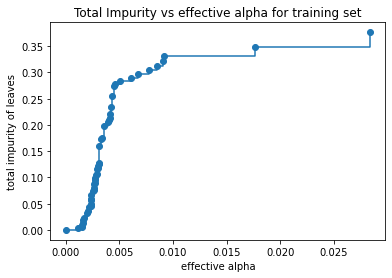

In [ ]:
# effective alpha값에 따른 total impurity of leaves 그래프

fig, ax = plt.subplots()
# plt.subplots() 편의 함수는 Figure 객체를 생성하고 Figure.subplots()를 호출하여 리턴
# axes: 좌표평면을 나타내는 변수

# ccp_alphas[-1]은 노드가 하나밖에 없는 트리임.
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# alpha 값이 커지면 트리가 작아짐 -> total impurity of leaves 커짐

In [ ]:
# effective alpha 값에 대응하는 sub-trees 시각화

clfs = []
count = 0
for ccp_alpha in ccp_alphas:
    # 각 effective alphas 이용해 decision tree 만들기
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf = clf.fit(X_train, y_train)
    count += 1
    print("Number of nodes in the {}th tree is: {} with ccp_alpha: {}".format(
      count, clf.tree_.node_count, ccp_alpha))
    display(draw_decision_tree(clf, feature_names, class_names))
    clfs.append(clf)
    print("====================================================================================")

# ccp_alpha = 0 일 때는 not-pruned full tree
# ccp_alpha를 0부터 시작해서 크기를 늘려감, effective alpha를 지나면 가지치기
# 마지막에는 root node만 남음
# alpha에 따라서 subtree의 크기를 조정할 수 있음을 확인

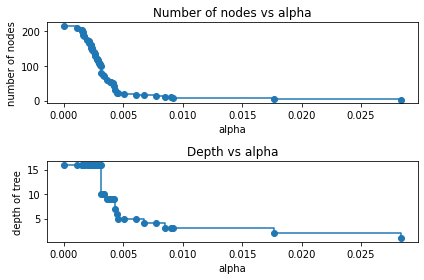

In [ ]:
# alpha값에 따른 node 수의 트리의 깊이

# 노드가 하나뿐인 마지막 tree는 제외
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# tree의 node 수
node_counts = [clf.tree_.node_count for clf in clfs]

# tree의 depth
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)
# Number of nodes vs alpha
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
# Depth vs alpha
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

# alpha 값이 커지면 트리는 작아지므로, node의 수와 트리의 깊이도 작아짐

- Accuracy vs alpha for training and testing sets
  - alpha 값에 대응하는 subtree의 성능 확인

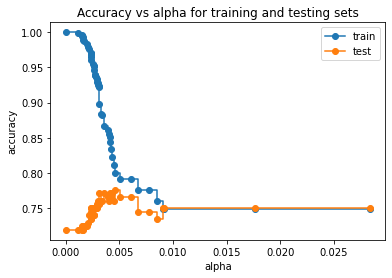

Decision tree without pruning : 215 nodes, 0.719 accuracy
Decision tree with the best pruning : 21 nodes, 0.776 accuracy


In [ ]:
# testing accuracy를 높이는 최고의 ccp_alpha는?

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

print("Decision tree without pruning : {0} nodes, {1:.3} accuracy".format(tree_nottuned.tree_.node_count, tree_nottuned.score(X_test, y_test)))
print("Decision tree with the best pruning : {0} nodes, {1:.3} accuracy".format(clfs[test_scores.index(max(test_scores))].tree_.node_count, max(test_scores)))

# 가장 높은 accuracy를 보이는 ccp_alpha 값은 약 0.004566727053140096
# effective alpha = 약 0.004566727053140096일 때 가장 높은 성능을 가지는 sub-tree가 만들어짐

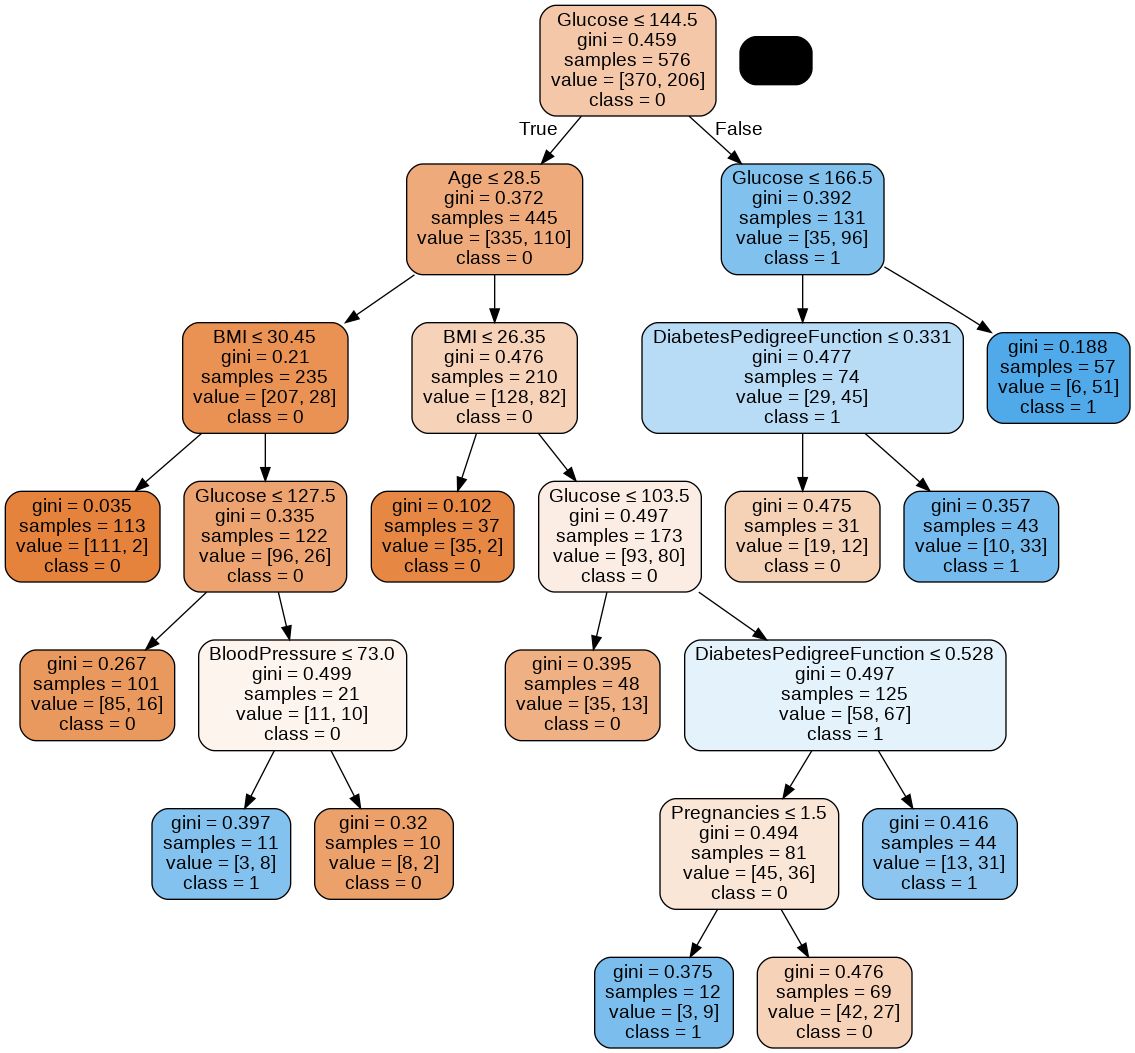

In [ ]:
# testing accuracy를 높이는 최고의 ccp_alpha
clf = DecisionTreeClassifier(random_state=0, ccp_alpha= 0.004566727)
clf = clf.fit(X_train, y_train)
draw_decision_tree(clf, feature_names, class_names)

# sub-trees 중 가장 성능 좋음
# overfitting 방지되었다고 추정